In [284]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import math
from typing import List
import numpy as np
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Generate a sample dataset -- Do not modify the generation code.

In [285]:
def generate_dataset(
    vocab_size: int = 50,
    num_examples: int = 1000,
    seed: int = 0,
) -> List[str]:
    """
    Generate a dataset for the associative recall task.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    tokens = torch.arange(vocab_size) + 1
    keys   = tokens[: (vocab_size // 2) - 1]
    values = tokens[((vocab_size // 2) - 1):-1]
    examples = []
    repeated = []
    golds = []
    for _ in range(num_examples):
        shuffled_keys = keys[torch.randperm(len(keys))]
        shuffled_values = values[torch.randperm(len(values))]
        kv_pairs = list(zip(shuffled_keys, shuffled_values))  
        example = kv_pairs[:4*len(kv_pairs) // 8]
        example += kv_pairs[:4*len(kv_pairs) // 8]
        example += kv_pairs[:4*len(kv_pairs) // 8]
        # shuffle example and repeat_pos
        perm = torch.randperm(len(example))
        example = [example[i] for i in perm]
        repeat_pos = []
        repeats = {}
        for i, (k, v) in enumerate(example):
            if int(k) in repeats:
                repeat_pos.append(i)
            repeats[int(k)] = int(v)
        example_tensor = torch.tensor(example).flatten()
        repeat_tensor = [i*2 for i in repeat_pos]
        gold = []
        for i in repeat_tensor:
            gold.append(int(example_tensor[i+1]))
        repeated.append(repeat_tensor)
        examples.append(example_tensor)
        golds.append(gold)
    examples = torch.stack(examples)
    return examples, repeated, golds

vocab_size=10

# in the example below, "9" is a gold prediction at position "2" since the "next-token" for the element at position "2" is a "9"
examples, repeated, golds = generate_dataset(vocab_size=vocab_size)
examples[0], repeated[0], examples[0][repeated[0]], golds[0]

(tensor([2, 9, 2, 9, 2, 9, 1, 5, 1, 5, 1, 5]),
 [2, 4, 8, 10],
 tensor([2, 2, 1, 1]),
 [9, 9, 5, 5])

#### Embeddings -- We have provided sufficient embeddings for you.

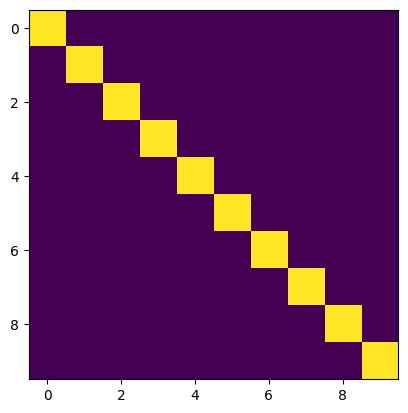

In [286]:
# Define the one-hot token embeddings 
emb_pos_2_tok_id = {}
embeddings_init = torch.zeros(vocab_size, vocab_size)
for i in range(vocab_size):
    embeddings_init[i][i] = 1
    emb_pos_2_tok_id[i] = embeddings_init[i]
plt.imshow(embeddings_init.detach().numpy())

12


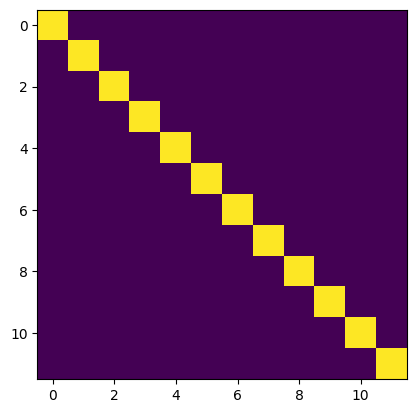

In [287]:
# Define the positional embeddings
batch_size, sequence_length = examples.shape[0], examples.shape[1]
seq_len = sequence_length 
positional_encodings = torch.zeros((seq_len, seq_len))
for pos in range(seq_len):
    positional_encodings[pos][pos] = 1
plt.imshow(positional_encodings.detach().numpy())
print(seq_len)

Sequence length: 12
Model Dimension: 22
Visualizing our input example's embeddings:


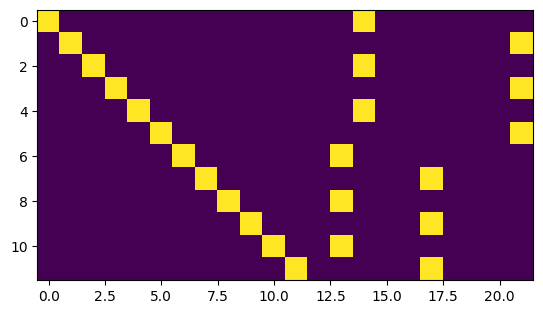

In [288]:
# embed the input
position_dim, embed_dim = positional_encodings.shape[1], embeddings_init.shape[1]
d_model = position_dim + embed_dim 
embs = torch.zeros((batch_size, seq_len, d_model))
for i in range(len(examples)):
    for j in range(len(examples[i])):
        embs[i][j] = torch.concat((positional_encodings[j], embeddings_init[examples[i][j]]))

print(f"Sequence length: {seq_len}")
print(f"Model Dimension: {d_model}")
print(f"Visualizing our input example's embeddings:")
plt.imshow(embs[0].detach().numpy())

#### Solution -- Enter Code for the # TODO's
- Note that we will ignore the MLPs and Multi-Heading
- Note that we will ignore the LayerNorms

In [6]:
# Layer 1: Shift over the token embeddings by one position.
K = torch.eye(d_model) 
Q = torch.zeros_like(K) 
V = torch.zeros_like(K) 

# Hard Code the Weights for K, Q, V
K = # TODO
Q = # TODO
V = # TODO

# Compute Attention Output
O1 = # TODO

# Residual 
z1 = O1 + embs

# Layer 2: Grab the value on key matches
K2 = torch.zeros(d_model, d_model)
Q2 = torch.eye(d_model) 
V2 = torch.eye(d_model)

# Hard Code the Weights for K2, Q2, V2
K2 = # TODO
Q2 = # TODO
V2 = # TODO

# Compute Attention Output
O2 = # TODO

# Compute the output by removing the spots for the positional embeddings
preds = torch.argmax(O2, dim=-1) - (position_dim)

### Score the Results

In [7]:
def score_solution(
    repeated: torch.Tensor, 
    predictions: torch.Tensor,
    golds: torch.Tensor,
) -> float:
    """
    Score a solution to the associative recall task.
    golds is [batch_size x num_golds]
    repeated is [batch_size x num_golds] locations of the repeated keys
    predictions is [batch_size x sequence_length]
    """
    correct = 0
    total = 0
    incorrect_indices = []
    for idx, (gold, repeat_positions, preds) in enumerate(zip(golds, repeated, predictions)):
        assert len(repeat_positions) == len(gold), print(f"{idx}: {len(repeat_positions)} != {len(gold)} -- repeat: {repeat_positions}, gold: {gold}")
        num_correct = len([True for j, i in enumerate(repeat_positions) if gold[j] == preds[i]])
        correct += num_correct
        total += len(gold)
        if num_correct != len(gold):
            incorrect_indices.append(idx)
    print(f"Accuracy: {correct / total}, sample size {total}, over {len(examples)} examples")
    return incorrect_indices

In [8]:
incorrect_indices = score_solution(repeated, preds, golds)
incorrect_indices[:10]

Accuracy: 1.0, sample size 4000, over 1000 examples


[]

#### Visualize the Steps
- A sample from a correct solution is provided below

Input
tensor([2, 5, 1, 6, 2, 5, 2, 5, 1, 6, 1, 6])
q1


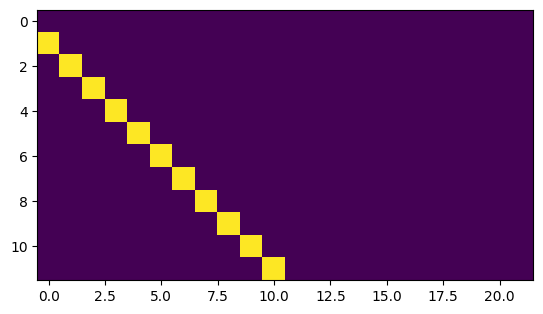

k1


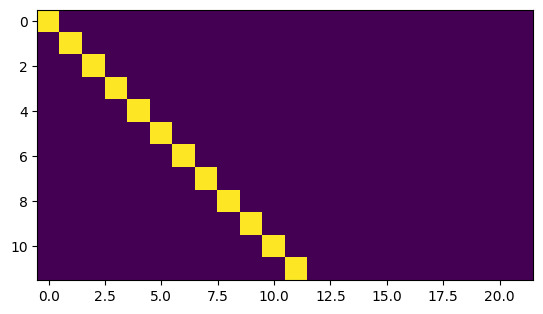

v1


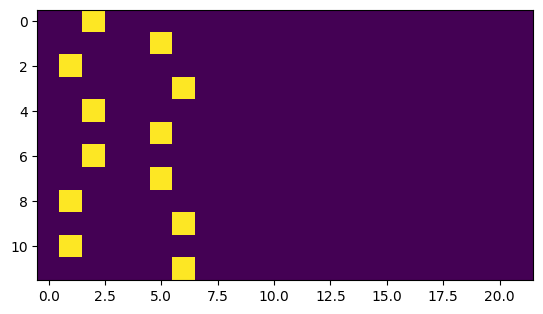

S1


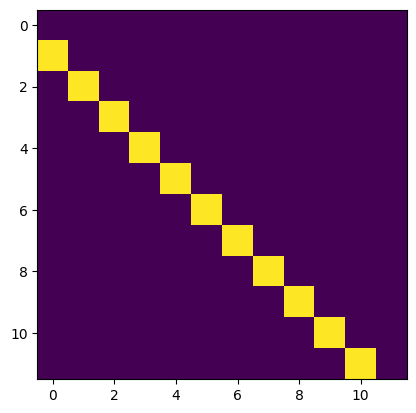

O1


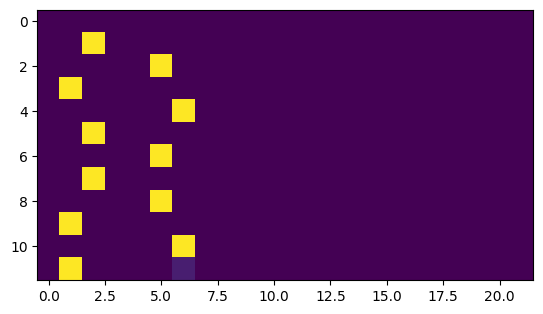

q2


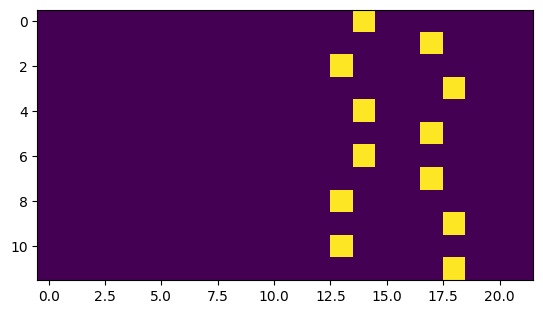

k2


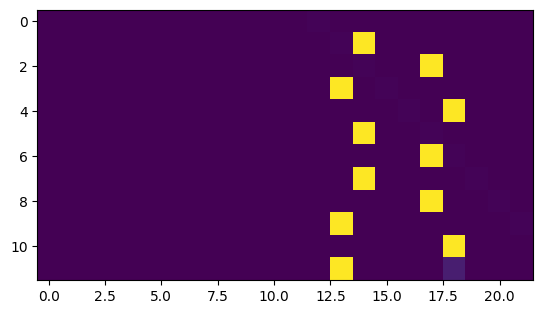

v2


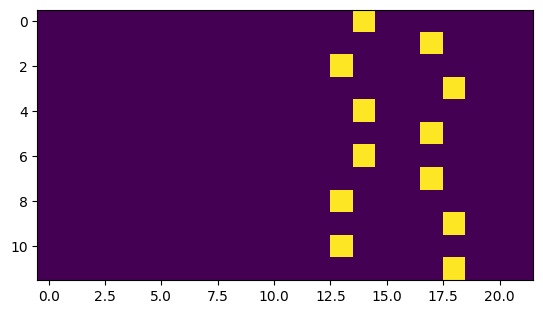

S2


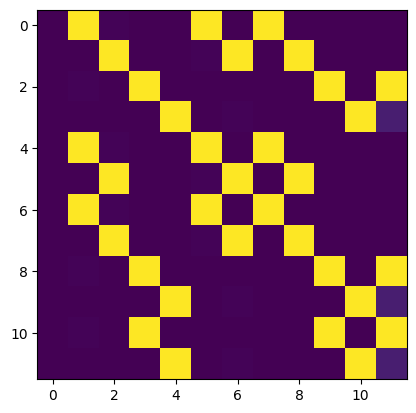

O2


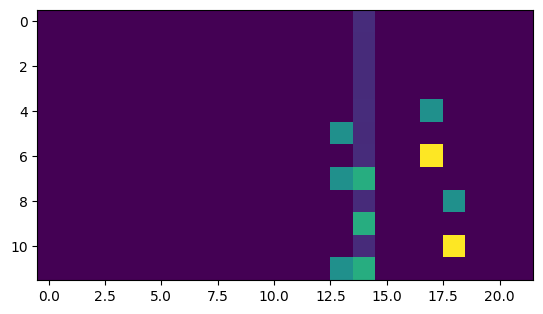

In [11]:
idx = 1

print("Input")
print(examples[idx])

print("q1")
plt.imshow(q1[idx].detach().numpy())
plt.show()
print("k1")
plt.imshow(k1[idx].detach().numpy())
plt.show()
print("v1")
plt.imshow(v1[idx].detach().numpy())
plt.show()
print("S1")
plt.imshow(S1[idx].detach().numpy())
plt.show()
print("O1")
plt.imshow(O1[idx].detach().numpy())
plt.show()

print("q2")
plt.imshow(q2[idx].detach().numpy())
plt.show()
print("k2")
plt.imshow(k2[idx].detach().numpy())
plt.show()
print("v2")
plt.imshow(v2[idx].detach().numpy())
plt.show()
print("S2")
plt.imshow(S2[idx].detach().numpy())
plt.show()
print("O2")
plt.imshow(O2[idx].detach().numpy())
plt.show()